In [4]:
import collections  # 导入collections模块，用于统计和操作容器数据，如Counter
import torch  # 导入PyTorch库，用于深度学习任务
import torch.nn as nn  # 从torch中导入神经网络模块，简化模型构建
from torch.utils.data import TensorDataset  # 导入TensorDataset，用于将Tensor数据打包成数据集
import numpy as np  # 导入NumPy库，用于高效的数值计算和数组操作
from sklearn.neighbors import NearestNeighbors  # 导入最近邻算法，用于在SMOTE中寻找相邻样本
import time  # 导入time模块，用于计时
import os  # 导入os模块，用于文件和目录操作

In [5]:
print(torch.version.cuda)  # 打印当前PyTorch使用的CUDA版本，例如显示"10.1"

t3 = time.time()  # 记录程序开始时的时间，用于后续计算总运行时间
##############################################################################
"""args for AE"""
# 以下部分设置自动编码器（AE）的相关参数
args = {}  # 创建一个空字典，用于存放模型和训练的参数
args['dim_h'] = 64         # 设置隐藏层通道数的基础因子，后续卷积层的通道数会成倍增加
args['n_channel'] = 1  #3    # 输入数据的通道数，1表示灰度图（3则为彩色图）；这里选用灰度图
args['n_z'] = 300 #600     # 潜在空间（编码空间）的维度数，决定编码器输出特征向量的大小
args['sigma'] = 1.0        # 潜在空间中使用的方差参数，可用于正则化
args['lambda'] = 0.01      # 判别器损失的权重超参数（如在对抗训练中使用）
args['lr'] = 0.0002        # Adam优化器的学习率，决定参数更新的步长
args['epochs'] = 50       # 训练过程中遍历数据集的轮数
args['batch_size'] = 64   # 每个训练批次的样本数量
args['save'] = True        # 如果为True，则在每个训练轮结束时保存模型权重
args['train'] = True       # 若为True则进行训练，否则加载已保存的模型进行测试
args['dataset'] = 'mnist34'  #'fmnist' # 指定使用的数据集，这里选择MNIST数据集 mnist34 mnist17 fashionmnist34 cifar10
args['fraction'] = 0.005   # 用于训练的数据集的子集比例，可用于快速测试

##############################################################################
print(args)

None
{'dim_h': 64, 'n_channel': 1, 'n_z': 300, 'sigma': 1.0, 'lambda': 0.01, 'lr': 0.0002, 'epochs': 50, 'batch_size': 64, 'save': True, 'train': True, 'dataset': 'mnist34', 'fraction': 0.005}


In [6]:
import torch.nn.functional as F
# Attention Block
class AttentionBlock(nn.Module):
    def __init__(self, filters):
        """
        :param filters: 输入特征图的通道数(同时也是卷积输出的通道数)
        """
        super(AttentionBlock, self).__init__()
        # 与 Keras 中的 Conv2D(filters, kernel_size=1, padding='same') 对应
        # PyTorch 中 padding=0 就相当于 'same'（仅当 kernel_size=1 时）
        self.query_conv = nn.Conv2d(filters, filters, kernel_size=1, padding=0)
        self.key_conv   = nn.Conv2d(filters, filters, kernel_size=1, padding=0)
        self.value_conv = nn.Conv2d(filters, filters, kernel_size=1, padding=0)

    def forward(self, x):
        """
        x 的形状一般是 (batch_size, filters, H, W)
        """
        # 1. 分别得到 query, key, value
        query = F.relu(self.query_conv(x))
        key   = F.relu(self.key_conv(x))
        value = F.relu(self.value_conv(x))

        # 2. 计算注意力图: 先元素乘，再对通道维度 (dim=1) 求和
        attention_map = query * key                  # 形状 (N, filters, H, W)
        attention_map = torch.sum(attention_map, dim=1, keepdim=True)  
        # 现在 attention_map 的形状是 (N, 1, H, W)

        # 3. 对空间维度 (H, W) 做 softmax
        # 先展平再 softmax，再 reshape 回去
        N, _, H, W = attention_map.shape
        attention_map = attention_map.view(N, 1, -1)         # (N, 1, H*W)
        attention_map = F.softmax(attention_map, dim=-1)     # 在 H*W 上做 softmax
        attention_map = attention_map.view(N, 1, H, W)       # (N, 1, H, W)

        # 4. 注意力加权 value，并与原输入相加
        attended_value = attention_map * value
        output = x + attended_value

        return output
# 定义编码器模型
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()  # 调用父类构造函数
        self.n_channel = args['n_channel']  # 获取输入数据的通道数
        self.dim_h = args['dim_h']          # 获取隐藏层基本通道数
        self.n_z = args['n_z']              # 获取潜在空间的维度数
        
        # 使用卷积层提取图像特征
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),  
            # 第一层卷积：输入通道数为n_channel，输出为dim_h，卷积核大小4，步幅2，填充1，无偏置
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 使用LeakyReLU激活函数，负半部斜率设为0.2
            AttentionBlock(filters=self.dim_h),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),  
            # 第二层卷积：通道数翻倍到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 对第二层卷积输出进行批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),  
            # 第三层卷积：通道数增加到dim_h*4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True),  # 激活函数
            
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),  
            # 第四层卷积：通道数增加到dim_h*8
            
            #3d and 32 by 32
            #nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 1, 0, bias=False),  # 备用卷积层配置
            nn.BatchNorm2d(self.dim_h * 8),  # 对第四层卷积输出进行批归一化
            #nn.ReLU(True),
            nn.LeakyReLU(0.2, inplace=True)  # 激活函数
            # 注释中还有其他可能的卷积配置，这里使用的是标准配置
        )
        # 全连接层：将卷积层输出映射到潜在空间
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)  
        # 这里计算dim_h * (2**3)相当于dim_h*8，假设卷积层最后输出特征数为dim_h*8

    def forward(self, x):
        # 前向传播函数
        # print('enc')  # 调试打印，可查看编码器被调用
        # print('input ', x.size())  # 打印输入尺寸，例如torch.Size([batch_size, channel, H, W])
        x = self.conv(x)  # 将输入图像通过卷积层提取特征
        x = x.squeeze()   # 去除多余的尺寸（例如将[batch_size, 1, N]变为[batch_size, N]）
        # print('aft squeeze ', x.size())  # 调试打印压缩后的尺寸
        x = self.fc(x)    # 通过全连接层映射到潜在空间维度
        # print('out ', x.size())  # 打印最终输出尺寸，应为[batch_size, n_z]
        return x  # 返回编码后的潜在表示

# 定义解码器模型
class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()  # 调用父类构造函数
        self.n_channel = args['n_channel']  # 获取输入通道数（用于输出重构图像）
        self.dim_h = args['dim_h']          # 获取隐藏层基本通道数
        self.n_z = args['n_z']              # 获取潜在空间的维度数

        # 全连接层：将潜在向量映射到足够重构卷积特征图的尺寸
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),  # 将潜在向量转换为高维特征，尺寸为[batch_size, dim_h*8*7*7]
            nn.ReLU()  # 使用ReLU激活函数
        )

        # 反卷积层（转置卷积）：将全连接层的输出转换为图像
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),  
            # 第一层反卷积：将通道数从dim_h*8降到dim_h*4，卷积核大小4
            nn.BatchNorm2d(self.dim_h * 4),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),  
            # 第二层反卷积：将通道数从dim_h*4降到dim_h*2
            nn.BatchNorm2d(self.dim_h * 2),  # 批归一化
            nn.ReLU(True),  # 激活函数
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),  
            # 第三层反卷积：将通道数降为1，同时上采样（步幅为2），恢复到原图大小
            # nn.Sigmoid())  # 也可用Sigmoid激活函数使输出在[0,1]之间
            nn.Tanh()  # 这里使用Tanh激活函数，将输出映射到[-1,1]
        )

    def forward(self, x):
        # 前向传播函数
        # print('dec')  # 调试打印，查看解码器调用
        # print('input ', x.size())  # 打印输入潜在向量的尺寸
        x = self.fc(x)  # 通过全连接层处理潜在向量
        x = x.view(-1, self.dim_h * 8, 7, 7)  
        # 将全连接层输出重塑为特征图，尺寸为[batch_size, dim_h*8, 7, 7]，为反卷积做准备
        x = self.deconv(x)  # 通过反卷积层重构出图像
        return x  # 返回重构图像

This is the MNIST dataset with labels 3 and 4.
Imbalanced Ratio:  0.1
Number of label 3 in the final training set:  6131
Number of label 4 in the final training set (after downsampling):  613
Number of label 3 in the final test set:  1010
Number of label 4 in the final test set:  982
Total samples in final training set:  6744
Total samples in final test set:  1992
Number of batches in training set:  106
Number of batches in test set:  32
Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First image tensor:
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

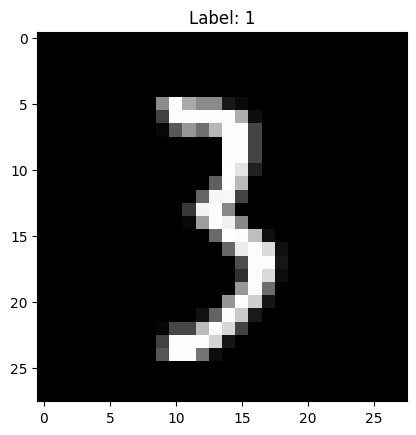

X_train.shape: (6744, 784)
y_train.shape: (6744,)
X_test.shape: (1992, 784)
y_test.shape: (1992,)
Encoder(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): AttentionBlock(
      (query_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (key_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kern

In [ ]:
from Get_datasets import get_datasets
X_train, y_train, X_test, y_test,train_loader,test_loader = get_datasets(dataname="mnist34",fraction=0.1)  # 获取数据集
encoder = Encoder(args)  # 创建编码器模型
decoder = Decoder(args)  # 创建解码器模型
print(encoder)
print(decoder)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 检测GPU是否可用
encoder = encoder.to(device)
decoder = decoder.to(device)  # 将模型移动到GPU上
train_on_gpu = torch.cuda.is_available()  # 检测GPU是否可用
#Deconder loss function
criterion = nn.MSELoss()  # 定义均方误差损失函数
criterion = criterion.to(device)  # 将损失函数移动到GPU上

dec_x = X_train  # 获取训练数据
dec_y = y_train  # 获取训练标签
print('train image shape:', dec_x.shape)  # 打印训练数据形状
print('train label shape:', dec_y.shape)  # 打印训练标签形状
#print('train image:', dec_x)  # 打印训练数据
#print('train label:', dec_y)  # 打印训练标签
print(collections.Counter(dec_y))  # 使用Counter统计每个类别的样本数量
dec_x = dec_x.reshape(-1, 1, 28, 28)  # 将训练数据重塑为合适的形状
print('train image shape:', dec_x.shape)  # 打印重塑后的训练数据形状
batch_size = args['batch_size']  # 获取批次大小
num_workers = 0  # 设置数据加载器的线程数
tensor_x = torch.Tensor(dec_x)  # 将NumPy数组转换为PyTorch张量
tensor_y = torch.tensor(dec_y, dtype = torch.long)  # 将NumPy数组转换为PyTorch张量
print('(Features)Tensor Dec_X:',tensor_x.shape)
print('(Labels)Tensor Dec_y:',tensor_y.shape)

mnist_train  =  TensorDataset(tensor_x, tensor_y)  # 将特征和标签打包为数据集
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True)  # 创建数据加载器
print('train_loader:',train_loader)
classes = ('0','1') # binary classification
best_loss = np.inf  # 初始化最佳损失为无穷大

t0 = time.time()  # 记录当前时间，用于计算训练时间
if args['train']:
    fraction = args['fraction']  # 获取数据集子集比例
    encoder_optim = torch.optim.Adam(encoder.parameters(), lr=args['lr'])  # 创建编码器的Adam优化器
    decoder_optim = torch.optim.Adam(decoder.parameters(), lr=args['lr'])  # 创建解码器的Adam优化器

    for epoch in range(args['epochs']):
        train_loss = 0.0  # 初始化训练损失为0
        tmse_loss = 0.0 # 初始化均方误差损失为0
        tdiscr_loss = 0.0 # 初始化判别器损失为0
        encoder.train()  # 设置编码器为训练模式
        decoder.train()
        for images, labels in train_loader: # 从数据加载器中加载数据
            encoder_optim.zero_grad()
            decoder_optim.zero_grad()
            images = images.to(device)
            labels = labels.to(device)
            labsn = labels.detach().cpu().numpy()  # 将标签转换为NumPy数组
            #print('labsn:',labsn.shape, labsn)
            z_hat = encoder(images) # 通过编码器生成潜在向量
            x_hat = decoder(z_hat) # 通过解码器生成重构图像
            mse_loss = criterion(x_hat, images) # 计算重构图像与原始图像的均方误差
            #print('mse_loss:',mse_loss)
            resx = [] 
            resy = []
            tc = 0 # 固定类别
            xbeg = dec_x[dec_y == tc]  # 从全局训练图像dec_x中选择标签等于c的所有样本
            ybeg = dec_y[dec_y == tc]  # 从全局标签dec_y中选择标签等于c的所有样本
            xlen = len(xbeg)
            #print('xbeg:',xbeg.shape)
            nsample = min(100, xlen)  # 生成样本数
            ind = np.random.choice(list(range(xlen)), nsample, replace=False)  # 随机选择nsample个样本
            xclass = xbeg[ind]  # 选择对应的图像
            yclass = ybeg[ind]
            xclen = len(xclass)
            xcminus = np.arange(1,xclen) # 1 to xclen-1
            xcplus = np.append(xcminus, 0 ) # 0 to xclen-2

            xcnew = (xclass[[xcplus], :])  

            xcnew = xcnew = xcnew.reshape(xcnew.shape[1], xcnew.shape[2], xcnew.shape[3], xcnew.shape[4]) # 1 to xclen-1, 0 to xclen-2
            #print('xcnew:',xcnew.shape)

            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
            xclass = xclass.detach().cpu().numpy()
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            #print('xc_enc:',xc_enc.shape)
            ximg = decoder(xc_enc)
            mse_loss2 = criterion(ximg, xcnew)
            #print('mse_loss2:',mse_loss2)
            combined_loss = mse_loss + mse_loss2
            combined_loss.backward()

            encoder_optim.step()
            decoder_optim.step()

            train_loss += combined_loss.item() * images.size(0)
            tmse_loss += mse_loss.item() * images.size(0)
            #print('train_loss:',train_loss)
            #print('tmse_loss:',tmse_loss)
            tdiscr_loss += mse_loss2.item() * images.size(0)
            #print('tdiscr_loss:',tdiscr_loss)


        # print training statistics
        train_loss = train_loss / len(train_loader.dataset)
        tmse_loss = tmse_loss / len(train_loader.dataset)
        tdiscr_loss = tdiscr_loss / len(train_loader.dataset)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                  train_loss, tmse_loss, tdiscr_loss))  
            # 打印当前epoch的损失信息
        # store the best encoder and decoder models
            # here, /crs5 is a reference to 5 way cross validation, but is not
            # necessary for illustration purposes
        if train_loss < best_loss:  
            # 如果当前epoch的平均损失低于历史最佳损失，则保存模型
            print('Saving..')
            path_enc = 'DeepSMOTE_{}_bst_enc.pth'.format(fraction)
            # 构造保存最佳编码器模型的文件路径
            path_dec = 'DeepSMOTE_{}_bst_dec.pth'.format(fraction)
            # 构造保存最佳解码器模型的文件路径
            
            torch.save(encoder.state_dict(), path_enc)  
            # 保存编码器当前状态字典（权重参数）
            torch.save(decoder.state_dict(), path_dec)  
            # 保存解码器当前状态字典
            
            best_loss = train_loss  # 更新历史最佳损失值
     # in addition, store the final model (may not be the best) for
    # informational purposes
    
    path_enc = 'DS_{}_final_enc.pth'.format(fraction)  
    # 构造保存最终编码器模型（可能不是最佳）的文件路径
    path_dec = 'DS_{}_final_dec.pth'.format(fraction)  
    # 构造保存最终解码器模型的文件路径
    print(path_enc)
    print(path_dec)
    torch.save(encoder.state_dict(), path_enc)  # 保存最终编码器状态
    torch.save(decoder.state_dict(), path_dec)  # 保存最终解码器状态
    print()
t1 = time.time()  # 记录当前fold训练结束时间
print('total time(min): {:.2f}'.format((t1 - t0) / 60))  
# 输出当前fold训练耗时（单位：分钟）

t4 = time.time()  # 记录整个程序结束时的时间
print('final time(min): {:.2f}'.format((t4 - t3) / 60))  
# 输出整个程序运行的总耗时（单位：分钟）